In [1]:
# try to import library, if it is not installed it will be downloaded
import os
try:
  import autoscattering
except:
  if not os.path.isdir('autoscattering'):
    !git clone https://github.com/jlandgr/autoscattering.git
    !mv autoscattering trash
    !mv trash/autoscattering .

In [2]:
import sympy as sp
import numpy as np
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import autoscattering.architecture_optimizer as arch_opt
import autoscattering.constraints as msc
import autoscattering.symbolic as sym
np.set_printoptions(linewidth=200)

In this example we reproduce the fully directional phase-preserving and quantum-limited amplifiers shown in Fig. 3(c) in our article [arxiv:2404.14887](https://arxiv.org/abs/2404.14887)

This example is motived by the work of [Liu et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.21.014021)

The goal is to design an amplifier which, which amplifies incoming signal by a factor of $G$, but has no backscattering at the input or output port. There should be no scattering from the output to the input port as the output port is connected to a room-temperature batch.
This corresponds to the target scattering matrix: $S_\mathrm{target} = \begin{pmatrix} 0&0\\ \sqrt{G} & 0 \end{pmatrix}$

Furthermore, the noise at the input and output ports should be at their respective quantum limits. The number of added noise photons at the input (mode 1) and output (mode 2) port can be computed at resonance ($\omega=0$) by:
$
\begin{align}
    N_\mathrm{input}^\mathrm{add}=\frac{1}{2} \sum_{k} \left( (n_k^\mathrm{in}+1) |S_{1k}|^2 + (n_k^\mathrm{noise}+1) |\mathcal{N}_{1k}|^2 \right) \\
    N_\mathrm{output}^\mathrm{add}=\frac{1}{2} \sum_{k\neq 1} \left( (n_k^\mathrm{in}+1) |S_{2k}|^2 + (n_k^\mathrm{noise}+1) |\mathcal{N}_{2k}|^2 \right)
\end{align}
$
$S_{ij}$ are the elements of the full scattering matrix which includes the scattering from and to the auxiliary modes. $\mathcal{N}_{ij}$ describes the linear response to fluctuations entering from the intrinsic loss channels at the port modes.
$n_k^\mathrm{in}$ and $n_k^\mathrm{noise}$ are the occupation numbers of the baths connected to the respective modes. We assume that all the baths are at zero temperature, except the bath connected to the output channel. So, $n_j^\mathrm{in}=0$ if $j\neq 2$, $n_j^\mathrm{noise}=0$ for all $j$, and $n_2^\mathrm{in} > 0$.

The quantum limit for a phase-preserving amplifiers is $N_\mathrm{input}^\mathrm{add}=1/2$ and $N_\mathrm{output}^\mathrm{add}=(G-1)/2$ (see [A. A. Clerk et al.](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.82.1155)). The value for $N_\mathrm{output}^\mathrm{add}$ can only be achieved if input and output mode are corotating. If they are counterrotating the commuation relations lead to additional photon, so such an amplifier can at best achieve $N_\mathrm{output}^\mathrm{add}=(G+1)/2$.

The quantum limit condition can not be directly expressed using a target scattering matrix. Instead, we define an extra constraints ($f_j$ in Equ. (1) in [arxiv:2404.14887](https://arxiv.org/abs/2404.14887)).

Please check [arxiv:2404.14887](https://arxiv.org/abs/2404.14887) for further details.

In the following we define these extra constraints.

In [3]:
class MinimalAddedInputNoise(msc.Base_Constraint):
    def __call__(self, scattering_matrix, coupling_matrix, kappa_int_matrix):
        '''
        calculates the difference between the number of added input photons and the quantum limit

        input arguments:
        scattering matrix: full scattering matrix for the current parameter set, this also includes the scattering from and to the auxiliary modes
        coupling matrix: dimensionless coupling matrix (sigma_z @ H in our equations) for the current parameter set, this constraint does not make any use of the coupling matrix
        kappa_int_matrix: diagonal matrix with the dimensionless intrinsic loss rates on the diagonal
        '''

        # calculate the linear response to fluctuations entering from the intrinsic loss channels (\mathcal{N} in the equations above)
        noise_matrix = (scattering_matrix - jnp.eye(scattering_matrix.shape[0])) @ jnp.complex_(jnp.sqrt(kappa_int_matrix))

        # calculate number of added photons at the input port, already considers that the target scattering matrix will be enforced
        total_noise = 1/2 * (jnp.sum(jnp.abs(scattering_matrix[0,2:])**2) + jnp.sum(jnp.abs(noise_matrix[0,:])**2))
        quantum_limit = 1/2
        return total_noise-quantum_limit

class MinimalAddedOutputNoise(msc.Base_Constraint):
    def __init__(self, Gval, input_output_corotating):
        '''
        Gval: target gain value
        input_output_corotating: True if input and output are corotating, False if they are counterrotating. In later case the minimum number of added photons is larger one photon.
        '''
        self.Gval = Gval
        self.input_output_corotating = input_output_corotating

    def __call__(self, scattering_matrix, coupling_matrix, kappa_int_matrix):
        '''
        calculates the difference between the number of added output photons and the quantum limit

        input arguments:
        scattering matrix: full scattering matrix for the current parameter set, this also includes the scattering from and to the auxiliary modes
        coupling matrix: dimensionless coupling matrix (sigma_z @ H in our equations) for the current parameter set, this constraint does not make any use of the coupling matrix
        kappa_int_matrix: diagonal matrix with the dimensionless intrinsic loss rates on the diagonal
        '''

        # calculate the linear response to fluctuations entering from the intrinsic loss channels (\mathcal{N} in the equations above)
        noise_matrix = (scattering_matrix - jnp.eye(scattering_matrix.shape[0])) @ jnp.complex_(jnp.sqrt(kappa_int_matrix))

        # calculate number of added photons at the output port, already considers that the target scattering matrix will be enforced
        total_noise = 1/2 * (jnp.sum(jnp.abs(scattering_matrix[1,2:])**2) + jnp.sum(jnp.abs(noise_matrix[1,:])**2))

        if self.input_output_corotating:
            quantum_limit = (self.Gval - 1)/2
        else:
            quantum_limit = (self.Gval + 1)/2

        return total_noise-quantum_limit


To achieve amplification squeezing interactions are required. As described in Appendix E, we focus on phase-preserving applications. Therefore, we can divide our mode sets into two subsets $M_1$ (particles) and $M_2$ (holes). Modes within the same subset are corotating and are exclusively coupled via beamsplitter interactions, modes in different subsets are counterrotating and are exclusively coupled via squeezing interactions. Which modes are part of which subset is controlled by the keyword argument mode_types. This is a list whose length equals the number of modes considered. An entry True means that a mode is a particle, False that it is a hole. All possible systems fulfill particle-hole symmetry, meaning that exchanging all particles by holes and vice versa, leads the same scattering behaviour (besides a complex conjugation of the scattering matrix).

In the following, we design the amplifiers with the target behaviour described above. We restrict ourselves to the building blocks used in [Liu et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.21.014021). This excludes intrinsic loss channels for the input and output mode.

We have to try out all possible combinations of particles and holes. However, considering particle-hole symmetry and that the system is symmetric with respect to exchange of auxiliary modes, reduces the amount of combinations.

Spoiler: At least 2 auxiliary modes are required leaving the following combinations for testing:
- [True, True, True, True] # does not offer any squeezing interactions and will therefore not provide amplification
- [False, True, True, True] # fully connected graph is invalid
- [True, False, True, True] # fully connected graph is invalid
- [True, True, False, True] # finds Graph (I), (II) and (UI). Graph (UI) is unstable and only discussed in the Supplemental Material
- [False, False, True, True] # fully connected graph is invalid
- [True, False, False, True] # finds Graph (III), (IV) and (UII). Graph (UII) is unstable and only discussed in the Supplemental Material

In [4]:
Gval = 3. # target gain value
mode_types = [True, True, False, True] # defines whether modes are co- or counterrotating 
S_target = sp.Matrix([[0,0],[np.sqrt(Gval),0]])
enforced_constraints = [MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval, input_output_corotating=mode_types[0]==mode_types[1])]

optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=2,
    mode_types=mode_types,
    port_intrinsic_losses=False, # no intrinsic losses on the port modes, this is also the default option
    enforced_constraints=enforced_constraints, # enforces quantum limited noise for input and output port, default is an empty list
    kwargs_optimization={'num_tests': 30}, # to reduce the risk of false negative classifications, we increase the number of tries till a graph is labeled is invalid
    solver_options={'maxiter': 2000}
)

fully connected graph is a valid graph


In [5]:
list_of_irreducible_graphs = optimizer.perform_depth_first_search()

prepare list of all possible graphs


3456it [00:00, 1520561.69it/s]


3456 graphs identified
start depth-first search
test all graphs with 16 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


test all graphs with 15 degrees of freedom:


100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


test all graphs with 14 degrees of freedom:


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


test all graphs with 13 degrees of freedom:


100%|██████████| 66/66 [00:06<00:00, 10.81it/s]


test all graphs with 12 degrees of freedom:


100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


test all graphs with 11 degrees of freedom:


100%|██████████| 153/153 [00:36<00:00,  4.20it/s]


test all graphs with 10 degrees of freedom:


100%|██████████| 102/102 [00:02<00:00, 45.97it/s]


test all graphs with 9 degrees of freedom:


100%|██████████| 32/32 [00:00<00:00, 98.91it/s]


test all graphs with 8 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 7 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]

optimisation finished, list of irreducible graphs has 7 elements


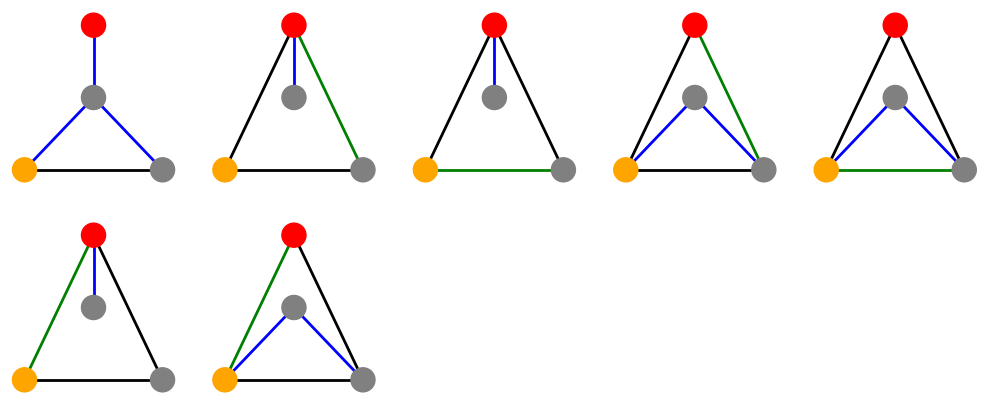

In [6]:
node_colors = ['orange', 'red', 'gray', 'gray'] # the input is orange, the output red, the auxiliary modes are gray
node_positions = [[-1,0],[0,1],[0,0.5],[1,0]]
msc.plot_list_of_graphs(list_of_irreducible_graphs, mode_types=mode_types, positions=node_positions, node_colors=node_colors)

In the following we will allow for intrinsic losses on the port modes. This building block was not considered in [Liu et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.21.014021).

Spoiler: 1 auxiliary mode will be suifficient leaving the combinations:
- [True, True, True] # does not provide squeezing
- [False, True, True] # fully connected graph is invalid
- [True, False, True] # finds Graph (V)
- [True, True, False] # fully connected graph is invalid

In [7]:

Gval = 3. # target gain value
mode_types = [True, False, True] # defines whether modes are co- or counterrotating 
S_target = sp.Matrix([[0,0],[np.sqrt(Gval),0]])
enforced_constraints = [MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval, input_output_corotating=mode_types[0]==mode_types[1])]

optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=1,
    mode_types=mode_types,
    port_intrinsic_losses=True, # allows an additional intrinsic loss channel for input and output port
    enforced_constraints=enforced_constraints, # enforces quantum limited noise for input and output port, default is an empty list
    kwargs_optimization={'num_tests': 30}, # to reduce the risk of false negative classifications, we increase the number of tries till a graph is labeled is invalid
    solver_options={'maxiter': 2000},
    make_initial_test=True
)

fully connected graph is a valid graph


In [8]:
list_of_irreducible_graphs = optimizer.perform_depth_first_search()

prepare list of all possible graphs


96it [00:00, 95733.04it/s]


96 graphs identified
start depth-first search
test all graphs with 9 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00, 28.06it/s]


test all graphs with 8 degrees of freedom:


100%|██████████| 4/4 [00:00<00:00, 84.01it/s]


test all graphs with 7 degrees of freedom:


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]

optimisation finished, list of irreducible graphs has 1 elements


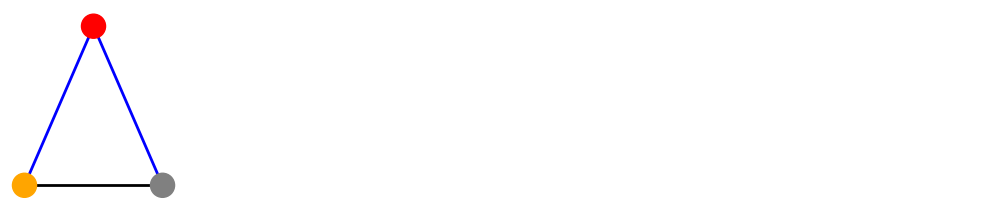

In [9]:
node_colors = ['orange', 'red', 'gray'] # the input is orange, the output red, the auxiliary modes are gray
node_positions = [[-1,0],[0,1],[1,0]]
msc.plot_list_of_graphs(list_of_irreducible_graphs, mode_types=mode_types, positions=node_positions, node_colors=node_colors)

In the following we analyse and generalise Graph (V) detected by the previous cells. So far, we always kept the gain value fixed. However, we want to find the general behaviour for arbitrary gain values. Playing around with the gain value, it is easy to see, that the cooperativities equal $C_{0,1}=C_{1,2}=G$ and $C_{0,2}=1$ and the dimensionless intrinsic loss rates equal $\gamma_0=0$ and $\gamma_1=G+1$.

In [10]:
Gval = 5. # target gain value
mode_types = [True, False, True] # defines whether modes are co- or counterrotating 

optimizer = arch_opt.Architecture_Optimizer(
    S_target=sp.Matrix([[0,0],[np.sqrt(Gval),0]]),
    num_auxiliary_modes=1,
    mode_types=mode_types,
    port_intrinsic_losses=True, # allows an additional intrinsic loss channel for input and output port
    enforced_constraints=[MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval, input_output_corotating=mode_types[0]==mode_types[1])],
    kwargs_optimization={'num_tests': 30}, # to reduce the risk of false negative classifications, we increase the number of tries till a graph is labeled is invalid
    solver_options={'maxiter': 2000},
    make_initial_test=False
)

success, infos, _ = optimizer.repeated_optimization(triu_matrix=list_of_irreducible_graphs[0], **optimizer.kwargs_optimization, **optimizer.solver_options)
print('optimisation was successful:', success)
infos[-1]['parameters_for_analysis']

optimisation was successful: True


{'C_{0,1}': np.float64(5.000030725905995),
 'C_{0,2}': np.float64(1.0000059315640468),
 'C_{1,2}': np.float64(4.999997391514442),
 '\\gamma_0': np.float64(1e-08),
 '\\gamma_1': np.float64(5.999998770064515)}

In [11]:
Gvals = np.linspace(1.1, 5., 20)
list_C01 = []
list_C02 = []
list_C12 = []
list_gamma0 = []
list_gamma1 = []

for Gval in Gvals:
    optimizer = arch_opt.Architecture_Optimizer(
        S_target=sp.Matrix([[0,0],[np.sqrt(Gval),0]]),
        num_auxiliary_modes=1,
        mode_types=[True, False, True], # defines whether modes are co- or counterrotating
        port_intrinsic_losses=True, # allows an additional intrinsic loss channel for input and output port
        enforced_constraints=[MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval, input_output_corotating=mode_types[0]==mode_types[1])],
        kwargs_optimization={'num_tests': 30}, # to reduce the risk of false negative classifications, we increase the number of tries till a graph is labeled is invalid
        solver_options={'maxiter': 2000},
        make_initial_test=False
    )

    success, infos, _ = optimizer.repeated_optimization(triu_matrix=list_of_irreducible_graphs[0], **optimizer.kwargs_optimization, **optimizer.solver_options)
    print('optimisation was successful:', success)
    list_C01.append(infos[-1]['parameters_for_analysis']['C_{0,1}'])
    list_C02.append(infos[-1]['parameters_for_analysis']['C_{0,2}'])
    list_C12.append(infos[-1]['parameters_for_analysis']['C_{1,2}'])
    list_gamma0.append(infos[-1]['parameters_for_analysis']['\\gamma_0'])
    list_gamma1.append(infos[-1]['parameters_for_analysis']['\\gamma_1'])

optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True
optimisation was successful: True


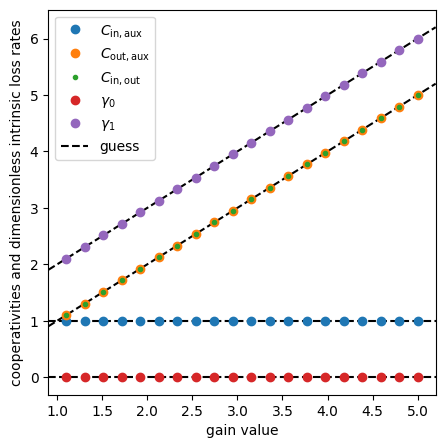

In [12]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(Gvals, list_C02, ls='None', marker='o', label='$C_\mathrm{in,aux}$')
ax.plot(Gvals, list_C12, ls='None', marker='o', label='$C_\mathrm{out,aux}$')
ax.plot(Gvals, list_C01, ls='None', marker='o', label='$C_\mathrm{in,out}$', markersize=3)
ax.plot(Gvals, list_gamma0, ls='None', marker='o', label='$\gamma_0$')
ax.plot(Gvals, list_gamma1, ls='None', marker='o', label='$\gamma_1$')

# plot dependencies for the parameter values
xs = np.linspace(Gvals[0]-.2, Gvals[-1]+.2)
ax.axhline(1., label='guess', ls='dashed', color='black', zorder=-100)
ax.axhline(0., ls='dashed', color='black', zorder=-100)
ax.plot(xs, xs, ls='dashed', color='black', zorder=-100)
ax.plot(xs, xs+1, ls='dashed', color='black', zorder=-100)
ax.set_xlabel('gain value')
ax.set_ylabel('cooperativities and dimensionless intrinsic loss rates')
ax.set_xlim(xs[0], xs[-1])
ax.legend()

In a similar way the other amplifiers with two auxiliary modes can be analysed. The easiest way to find the symbolic expressions is to find first the symbolic expressions for the full scattering matrix including the scattering from and to the auxiliary modes. The coupling matrix can then be computed by simple matrix inversion. The resulting coupling rates are provided in the Supplemental Material in [arxiv:2404.14887](https://arxiv.org/abs/2404.14887).